## **Configuración y Carga de Datos**

Se carga el dataset original de Diabetes y Estilo de Vida.

In [0]:
# Carga del dataset original
file_path = "/Volumes/workspace/default/actividad2/Diabetes_and_LifeStyle_Dataset.csv"
df_raw = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True
)

print("Conteo inicial:", df_raw.count())
display(df_raw.limit(5))

Conteo inicial: 97297


Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.8,129,76,67,116,55,50,30,93,150,2.0,5.63,23.0,No Diabetes,0
60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.2,23.5,Type 2,1


## **Generación y Transformación de Columnas de Fecha**

Dado que el dataset no posee una columna temporal, generaremos una fecha sintética consecutiva a partir del 2023-01-01 y derivaremos los atributos de tiempo (Año, Mes, Día, etc.).

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# 1. Generar fecha base consecutiva
# Se asigna una fecha única por fila incrementando días desde 2023-01-01
base_date = F.to_date(F.lit("2023-01-01"))
window_spec = Window.orderBy(F.monotonically_increasing_id())

df_dates = df_raw.withColumn("row_num", F.row_number().over(window_spec)) \
                 .withColumn("fecha", F.date_add(base_date, F.col("row_num") - 1)) \
                 .drop("row_num")

# 2. Derivar columnas: Año, Mes, Día, Día Semana, Nombre Día
df_transformed = (df_dates
  .withColumn("anio", F.year("fecha"))
  .withColumn("mes", F.month("fecha"))
  .withColumn("dia", F.dayofmonth("fecha"))
  .withColumn("dia_semana_num", F.date_format("fecha", "u").cast("int")) # 1=Lunes
  .withColumn("nombre_dia", F.date_format("fecha", "EEEE"))
)

display(df_transformed.select("fecha", "anio", "mes", "nombre_dia", "bmi").limit(10))

# Crear vista temporal
df_transformed.createOrReplaceTempView("diabetes_transformed")

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


fecha,anio,mes,nombre_dia,bmi
2023-01-01,2023,1,Sunday,30.5
2023-01-02,2023,1,Monday,23.1
2023-01-03,2023,1,Tuesday,22.2
2023-01-04,2023,1,Wednesday,26.8
2023-01-05,2023,1,Thursday,21.2
2023-01-06,2023,1,Friday,26.1
2023-01-07,2023,1,Saturday,25.1
2023-01-08,2023,1,Sunday,23.9
2023-01-09,2023,1,Monday,24.7
2023-01-10,2023,1,Tuesday,26.7


**En SQL**

Se verifica las columnas creadas usando SQL estándar.

In [0]:
%sql
-- Validación de las columnas derivadas
SELECT 
  fecha,
  year(fecha) AS anio_sql,
  date_format(fecha, 'EEEE') AS nombre_dia_sql,
  bmi,
  hba1c
FROM diabetes_transformed
LIMIT 5;

fecha,anio_sql,nombre_dia_sql,bmi,hba1c
2023-01-01,2023,Sunday,30.5,8.18
2023-01-02,2023,Monday,23.1,5.63
2023-01-03,2023,Tuesday,22.2,7.51
2023-01-04,2023,Wednesday,26.8,9.03
2023-01-05,2023,Thursday,21.2,7.2


## **Limpieza de Datos**

Se implementa la normalización de texto, manejo de valores nulos (si los hubiera) y limpieza de outliers (datos atípicos) en la columna bmi (Índice de Masa Corporal)

In [0]:
from pyspark.sql import functions as F, types as T

spark.conf.set(
    "spark.sql.legacy.timeParserPolicy",
    "LEGACY"
)

# Se define el data frame en el estado actual
df_before = df_transformed

# Se aplica la limpieza

#Se normaliza textos
df_clean = df_before.withColumn("gender_clean", F.lower(F.trim(F.col("gender")))) \
                    .withColumn("education_clean", F.upper(F.trim(F.col("education_level"))))

# Tratamiento de Outliers en BMI
quantiles = df_clean.approxQuantile("bmi", [0.25, 0.75], 0.01)
q1, q3 = quantiles[0], quantiles[1]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Límites para BMI: {lower_bound} - {upper_bound}")

# Se filtran valores extremos
df_clean = df_clean.filter((F.col("bmi") >= lower_bound) & (F.col("bmi") <= upper_bound))

# Antes vs Después

print("Texto sin normalizar, posibles outliers")
df_before.select("gender", "education_level", "bmi").summary("count", "mean", "max").show()
display(df_before.limit(10))

print("Texto normalizado, outliers removidos")
df_clean.select("gender_clean", "education_clean", "bmi").summary("count", "mean", "max").show()
display(df_clean.limit(10))


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Límites para BMI: 16.15 - 34.949999999999996
Texto sin normalizar, posibles outliers
+-------+------+---------------+-----------------+
|summary|gender|education_level|              bmi|
+-------+------+---------------+-----------------+
|  count| 97297|          97297|            97297|
|   mean|  NULL|           NULL|25.61509296278401|
|    max| Other|   Postgraduate|             39.2|
+-------+------+---------------+-----------------+



Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes,fecha,anio,mes,dia,dia_semana_num,nombre_dia
58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1,2023-01-01,2023,1,1,7,Sunday
52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.8,129,76,67,116,55,50,30,93,150,2.0,5.63,23.0,No Diabetes,0,2023-01-02,2023,1,2,1,Monday
60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1,2023-01-03,2023,1,3,2,Tuesday
74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1,2023-01-04,2023,1,4,3,Wednesday
46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.2,23.5,Type 2,1,2023-01-05,2023,1,5,4,Thursday
46,Female,White,Highschool,Upper-Middle,Employed,Never,2,124,9.0,6.2,5.4,0,0,0,26.1,0.85,95,81,57,218,61,119,179,100,133,8.77,6.03,23.5,Pre-Diabetes,0,2023-01-06,2023,1,6,5,Friday
75,Female,White,Graduate,Upper-Middle,Retired,Never,0,53,9.2,7.8,8.0,0,1,0,25.1,0.88,129,77,81,238,46,161,155,101,100,10.14,5.24,36.1,Pre-Diabetes,0,2023-01-07,2023,1,7,6,Saturday
62,Male,White,Postgraduate,Middle,Unemployed,Current,1,75,4.1,9.0,12.9,0,1,1,23.9,0.86,128,83,76,241,49,159,120,110,189,8.96,7.04,34.2,Type 2,1,2023-01-08,2023,1,8,7,Sunday
37,Male,Black,Highschool,Lower-Middle,Employed,Current,1,114,6.7,8.5,8.5,0,0,1,24.7,0.84,103,71,72,187,33,132,98,116,172,5.7,6.9,26.7,Type 2,1,2023-01-09,2023,1,9,1,Monday
59,Female,White,Graduate,Middle,Employed,Current,3,86,8.2,5.3,7.4,0,0,0,26.7,0.81,124,81,70,188,52,103,104,76,109,4.49,4.99,30.0,No Diabetes,0,2023-01-10,2023,1,10,2,Tuesday


Texto normalizado, outliers removidos
+-------+------------+---------------+------------------+
|summary|gender_clean|education_clean|               bmi|
+-------+------------+---------------+------------------+
|  count|       96394|          96394|             96394|
|   mean|        NULL|           NULL|25.613988422515884|
|    max|       other|   POSTGRADUATE|              34.9|
+-------+------------+---------------+------------------+



Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes,fecha,anio,mes,dia,dia_semana_num,nombre_dia,gender_clean,education_clean
58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1,2023-01-01,2023,1,1,7,Sunday,male,HIGHSCHOOL
52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.8,129,76,67,116,55,50,30,93,150,2.0,5.63,23.0,No Diabetes,0,2023-01-02,2023,1,2,1,Monday,female,HIGHSCHOOL
60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1,2023-01-03,2023,1,3,2,Tuesday,male,HIGHSCHOOL
74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1,2023-01-04,2023,1,4,3,Wednesday,female,HIGHSCHOOL
46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.2,23.5,Type 2,1,2023-01-05,2023,1,5,4,Thursday,male,GRADUATE
46,Female,White,Highschool,Upper-Middle,Employed,Never,2,124,9.0,6.2,5.4,0,0,0,26.1,0.85,95,81,57,218,61,119,179,100,133,8.77,6.03,23.5,Pre-Diabetes,0,2023-01-06,2023,1,6,5,Friday,female,HIGHSCHOOL
75,Female,White,Graduate,Upper-Middle,Retired,Never,0,53,9.2,7.8,8.0,0,1,0,25.1,0.88,129,77,81,238,46,161,155,101,100,10.14,5.24,36.1,Pre-Diabetes,0,2023-01-07,2023,1,7,6,Saturday,female,GRADUATE
62,Male,White,Postgraduate,Middle,Unemployed,Current,1,75,4.1,9.0,12.9,0,1,1,23.9,0.86,128,83,76,241,49,159,120,110,189,8.96,7.04,34.2,Type 2,1,2023-01-08,2023,1,8,7,Sunday,male,POSTGRADUATE
37,Male,Black,Highschool,Lower-Middle,Employed,Current,1,114,6.7,8.5,8.5,0,0,1,24.7,0.84,103,71,72,187,33,132,98,116,172,5.7,6.9,26.7,Type 2,1,2023-01-09,2023,1,9,1,Monday,male,HIGHSCHOOL
59,Female,White,Graduate,Middle,Employed,Current,3,86,8.2,5.3,7.4,0,0,0,26.7,0.81,124,81,70,188,52,103,104,76,109,4.49,4.99,30.0,No Diabetes,0,2023-01-10,2023,1,10,2,Tuesday,female,GRADUATE


## **Tabla de Resumen Mensual**

Se crea una tabla agregada para analizar la evolución de indicadores clave por mes.

In [0]:
# Agregación en PySpark
resumen_mensual = (df_clean.groupBy("anio", "mes")
  .agg(
    F.count("*").alias("total_registros"),
    F.round(F.avg("bmi"), 2).alias("promedio_bmi"),
    F.round(F.avg("hba1c"), 2).alias("promedio_hba1c"),
    F.sum("diagnosed_diabetes").alias("casos_diabetes")
  )
  .orderBy("anio", "mes")
)

resumen_mensual.write.format("delta").mode("overwrite").saveAsTable("resumen_mensual_diabetes")

print("Tabla 'resumen_mensual_diabetes' creada exitosamente.")

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Tabla 'resumen_mensual_diabetes' creada exitosamente.


In [0]:
%sql

SELECT * FROM resumen_mensual_diabetes LIMIT 12;

anio,mes,total_registros,promedio_bmi,promedio_hba1c,casos_diabetes
2023,1,31,25.1,6.65,19
2023,2,28,25.72,6.64,17
2023,3,31,25.67,6.76,23
2023,4,30,25.13,6.41,18
2023,5,30,26.05,6.58,19
2023,6,30,25.48,6.45,18
2023,7,31,25.95,6.78,21
2023,8,31,25.06,6.57,21
2023,9,30,25.71,6.61,20
2023,10,31,25.14,6.33,17


## **Visualizaciones Categóricas**

Utilizaremos matplotlib y seaborn convirtiendo una muestra o el resumen a Pandas, ya que estas librerías requieren datos locales

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


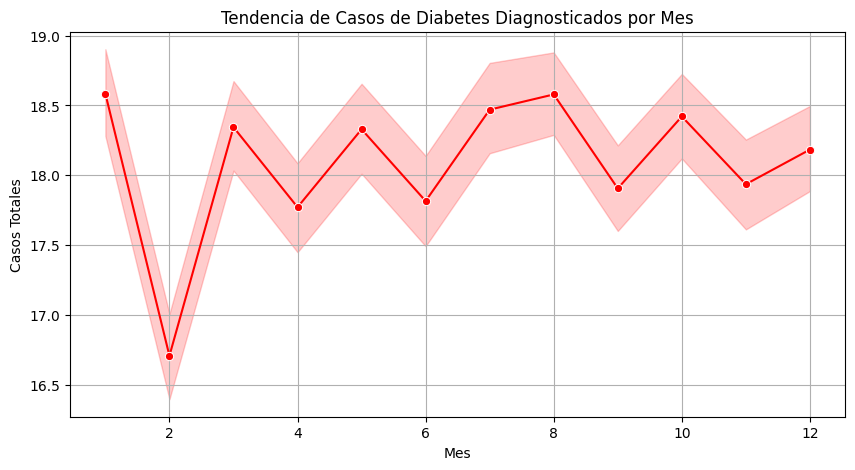

/home/spark-ca464a4c-9e55-453c-9110-61/.ipykernel/4209/command-5444042752977482-3602396423:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf_clean_sample, x="nombre_dia", y="bmi", order=order_days, palette="Set2")


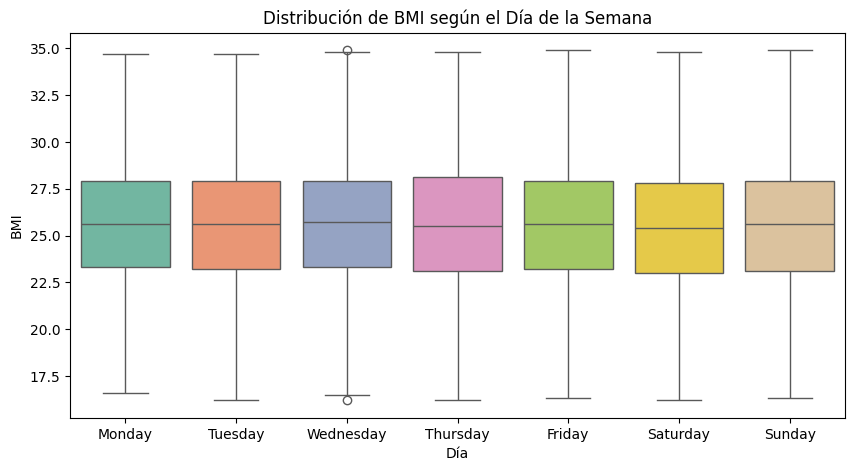

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertimos la tabla de resumen mensual a Pandas para visualizar tendencias
pdf_resumen = spark.table("resumen_mensual_diabetes").toPandas()

# Convertimos una muestra de los datos limpios para visualizar categorías
pdf_clean_sample = df_clean.select("nombre_dia", "gender_clean", "bmi", "diabetes_stage").sample(fraction=0.1, seed=42).toPandas()

# --- Gráfico 1: Tendencia Mensual de Casos de Diabetes (Líneas) ---
plt.figure(figsize=(10, 5))
sns.lineplot(data=pdf_resumen, x="mes", y="casos_diabetes", marker="o", color="red")
plt.title("Tendencia de Casos de Diabetes Diagnosticados por Mes")
plt.xlabel("Mes")
plt.ylabel("Casos Totales")
plt.grid(True)
plt.show()

# --- Gráfico 2: Distribución de BMI por Día de la Semana (Boxplot) ---
plt.figure(figsize=(10, 5))
# Ordenamos los días
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(data=pdf_clean_sample, x="nombre_dia", y="bmi", order=order_days, palette="Set2")
plt.title("Distribución de BMI según el Día de la Semana")
plt.xlabel("Día")
plt.ylabel("BMI")
plt.show()

## **Conclusiones**

1. Personalmente se me hace más facil trabajar las transformaciones y el manejo de datos con spark. 
2. Podría utilizar las consultas SQL para mostrar los resultados de las tranformaciones hechas con spark.
3. Comprendí la importancia de aprender a utilizar motores como Spark para el manejo de datos.